In [1]:
import updated_impyute 
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.metrics import mean_squared_error
import torch
from produce_NA import *
import importlib


In [2]:
# Function to generate synthetic data
def generate_synthetic_data(n_samples=100, n_features=5):
    mean = np.random.rand(n_features) * 10
    cov = np.random.rand(n_features, n_features)
    cov = np.dot(cov, cov.transpose())  # Ensure the covariance matrix is positive semi-definite
    data = multivariate_normal.rvs(mean=mean, cov=cov, size=n_samples)
    return data

In [3]:
# Generate synthetic data
data = generate_synthetic_data(n_samples=10000, n_features=5)
missing_data_info = produce_NA(data, 0.60 , mecha="MCAR")
X_incomp = missing_data_info['X_incomp'].numpy()

In [4]:
test = updated_impyute.em(X_incomp, eps=0.1)

In [5]:
print(mean_squared_error(data, test))

1.8458298234032493


In [6]:
def nan_covariance(data): #not sure how to initialise without a function like this, np.cov() does not work well as there is alot of NaN in the matrix
    n, m = data.shape # this function basicaly computes covariance ignoring the mssiing data
    means = np.nanmean(data, axis=0)
    data_filled = np.where(np.isnan(data), means, data)

    return np.cov(data_filled, rowvar=False)

In [7]:
print(nan_covariance(X_incomp))

[[1.92253121 0.27718718 0.29192713 0.16397423 0.12485186]
 [0.27718718 1.68548493 0.34853687 0.22507205 0.15226918]
 [0.29192713 0.34853687 1.77899979 0.29578803 0.1720525 ]
 [0.16397423 0.22507205 0.29578803 1.17939233 0.14524373]
 [0.12485186 0.15226918 0.1720525  0.14524373 0.46084032]]


In [8]:
def log_likelihood1(X, mu, Sigma):
    N=X.shape[0]
    p=X.shape[1]
    result=-N/2*np.log(np.linalg.det(Sigma))
    X_muT=X-mu.T
    for n in range(N):
        result=result-0.5*(X[n,:]-mu.T).dot(np.linalg.solve(Sigma, X[n,:].T-mu)) #is repetitively summing here bad?
    return result

In [9]:
def calculate_xhat(xn,mu,Sigma,missing_indices):
    #m=missing_indices.shape[0]
    p=Sigma.shape[0]
    
    xhatn=xn.copy()
    observed_indices=np.arange(p)[~np.isin(np.arange(p),missing_indices)]
    #appended_indices=np.append(observed_indices, missing_indices)
    
    Sigma22=Sigma[missing_indices,:][:,missing_indices]
    Sigma11=Sigma[observed_indices,:][:,observed_indices]
    Sigma21=Sigma[missing_indices,:][:,observed_indices]
    
    mu1=mu[observed_indices]
    mu2=mu[missing_indices]
    xhatn_1=xhatn[observed_indices]
    mu2_conditional=mu2+Sigma21.dot(np.linalg.solve(Sigma11,xhatn_1-mu1))
    #print(xhatn)
    #print(mu2_conditional,xhatn[missing_indices,],mu2_conditional.shape,xhatn[missing_indices,].shape)
    xhatn[missing_indices,] = mu2_conditional
    #this doesnt seem to work 
    #reason: Array is passed as a view, potential danger!
    #hmm still doesnt work wtf
    #Its because a numpy array of ints rounds floats that are added to it wtfffff, fixed now
    
    #print(xhatn.base)
    #print(mu2_conditional,xhatn[missing_indices])
    
    return xhatn

In [10]:
import numpy as np

def regularize_covariance(Sigma,eigenvalue_tol=1e-2,ridge_coefficient=5e-1,verbose=True):
    
    """
    regularizes covariance matrices with very small eigenvalues by adding lambda*In
    
    Sigma: (p,p) numpy array (positive definite covariance matrix, must be possible to do eigenvalue decomposition)
    
    eigenvalue_tol : threshold of the smallest eigenvalue that leads to regularization
    
    ridge_coefficient : the lambda such that lambda*In gets added if the threshold is reached
    """
    
    eigenvalues, eigenvectors = np.linalg.eig(Sigma)
    #eigenvectors are in the columns
    p=Sigma.shape[0]
    
    small_indices=np.where(eigenvalues<eigenvalue_tol)
    if verbose:
        print("The eigenvectors are the columns of :\n",eigenvectors)
        print("The smallest eigenvalue is :",min(eigenvalues))
        print("The eigenvalues below the tolerance of ", eigenvalue_tol," are :\n",eigenvalues[small_indices])
        print("We added ",ridge_coefficient," to the diagonal.")
    if len(small_indices)>0:
        Sigma=Sigma+ridge_coefficient*np.eye(p)
    return Sigma

In [11]:
def calculate_C(Sigma,missing_indices,verbose=False):
    p=Sigma.shape[0]
    m=missing_indices.shape[0]
    if verbose:
        print("Original unconditional covariance : \n",Sigma)
    observed_indices=np.arange(p)[~np.isin(np.arange(p),missing_indices)]
    appended_indices=np.append(observed_indices, missing_indices)
    Sigma=(Sigma[appended_indices,:])[:,appended_indices]
    
    if verbose:
        print("Unconditional covariance rearranged so that missing indices are at the bottom : \n",Sigma)
    Sigma11=Sigma[0:(p-m),0:(p-m)]
    Sigma21=Sigma[(p-m):p,0:(p-m)]
    Sigma22=Sigma[(p-m):p,(p-m):p]
    Sigma22_conditional=Sigma22-Sigma21.dot(np.linalg.solve(Sigma11,Sigma21.T))
    
    reverse_permutation=np.argsort(appended_indices)
    result=np.full((p,p),0)
    result[(p-m):p,(p-m):p]=Sigma22_conditional
    if verbose:
        print("The conditional covariance when ordered is : \n",result)
    result=(result[reverse_permutation,:])[:,reverse_permutation]
    if verbose:
        print("After permuting back we get : \n", result)
    return(result)

In [12]:
def em_algorithm1(data, max_iter=100, tol=1e-6):
    n, p = data.shape

    # Initialize mean and covariance estimates
    means = np.nanmean(data, axis=0)
    covariance = nan_covariance(data)
    covariance = regularize_covariance(covariance)

    # Create an array to hold imputed data
    imputed_data = np.where(np.isnan(data), np.nanmean(data, axis=0), data)
    #imputed_data = np.where(np.isnan(data), None, data)
    
    old_log_likelihood = log_likelihood1(imputed_data, means, covariance)
    #print(old_log_likelihood)

    for iteration in range(max_iter):
        # E-step: Estimate missing values
        for i in range(n):
            missing = np.where(np.isnan(data[i]))[0]
            if np.isnan(data[i]).any():
                imputed_data[i,] = calculate_xhat(imputed_data[i,],means,covariance,missing) #this function works with Nans in the missing entries too, why do we impute?

        # M-step: Update mean and covariance estimates
        means = np.mean(imputed_data, axis=0)
        new_covariance = np.full((p,p),0) 

        # Add the conditional covariance for missing data
        for i in range(n):
            missing = np.where(np.isnan(data[i]))[0]
            #if missing.any(): #with this condition, are you not skipping xhat-mu *(xhat-mu).T when there is no missing data? I think so...
            new_covariance = new_covariance + calculate_C(covariance,missing,verbose=False) + (imputed_data[i,]-means).reshape(-1, 1) @ np.transpose((imputed_data[i,]-means).reshape(-1, 1))
            
        covariance = new_covariance/n 
        covariance = regularize_covariance(covariance)
        #print(covariance)
        # Convergence test based on log likelihood
        new_log_likelihood = log_likelihood1(imputed_data, means, covariance)
        #print(new_log_likelihood)
        difference=new_log_likelihood - old_log_likelihood
        #print("The new log likelihood is :", new_log_likelihood, "  Difference of : ",difference)
        
        if np.abs(difference) < tol: #absolute value not necessary and potentially undesirable, as in theory should always be positive
            #print("Convergence achieved! \n")
            break
        old_log_likelihood = new_log_likelihood

    return imputed_data,means,covariance

In [13]:
imputed_data, _, _ = em_algorithm1(X_incomp)

The eigenvectors are the columns of :
 [[-5.71317127e-01 -4.15308217e-02  8.16778957e-01  3.18040381e-02
   6.10947543e-02]
 [-5.00471142e-01 -6.65457157e-02 -3.00927402e-01  1.70390044e-01
  -7.90892050e-01]
 [-5.69083172e-01 -6.98536716e-02 -4.58845390e-01  3.05136292e-01
   6.06314736e-01]
 [-2.84156255e-01 -1.31547433e-01 -1.73346907e-01 -9.32073951e-01
   5.60312066e-02]
 [-1.36106364e-01  9.85729474e-01 -4.15522766e-02 -8.99206850e-02
  -3.74433800e-04]]
The smallest eigenvalue is : 0.4137249635620072
The eigenvalues below the tolerance of  0.01  are :
 []
We added  0.5  to the diagonal.
The eigenvectors are the columns of :
 [[-5.71317127e-01 -4.15308217e-02  8.16778957e-01  3.18040381e-02
   6.10947543e-02]
 [-5.00471142e-01 -6.65457157e-02 -3.00927402e-01  1.70390044e-01
  -7.90892050e-01]
 [-5.69083172e-01 -6.98536716e-02 -4.58845390e-01  3.05136292e-01
   6.06314736e-01]
 [-2.84156255e-01 -1.31547433e-01 -1.73346907e-01 -9.32073951e-01
   5.60312066e-02]
 [-1.36106364e-01  9

In [14]:
print(mean_squared_error(data, imputed_data))

1.8458298234032493


The eigenvectors are the columns of :
 [[-0.57049064 -0.6623867   0.05469725 -0.48199213 -0.02181911]
 [-0.31359327  0.19201309  0.90172937  0.20519601  0.09782117]
 [-0.45417863  0.68071209 -0.17109121 -0.40033991 -0.37524469]
 [-0.53935017 -0.1015725  -0.3163472   0.75057859 -0.18799107]
 [-0.28111002  0.22514198 -0.23354787 -0.04402171  0.90211182]]
The smallest eigenvalue is : 0.07708064790361718
The eigenvalues below the tolerance of  0.01  are :
 []
We added  0.5  to the diagonal.
The eigenvectors are the columns of :
 [[ 0.56870356  0.52394102 -0.4028451   0.38222368 -0.3060767 ]
 [ 0.31624623 -0.67171661 -0.64053774 -0.08219869  0.17815692]
 [ 0.45898625 -0.44851715  0.53772633  0.06373519 -0.54309503]
 [ 0.53383616  0.2616819   0.17007711 -0.71815598  0.31916656]
 [ 0.28445588 -0.06809959  0.33068323  0.57213481  0.69120016]]
The smallest eigenvalue is : 0.030826464182773843
The eigenvalues below the tolerance of  0.01  are :
 []
We added  0.5  to the diagonal.
The eigenvector

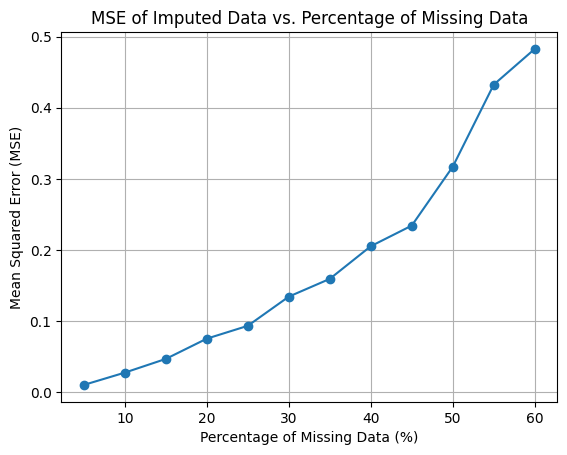

In [15]:
# Generate synthetic data
data = generate_synthetic_data(n_samples=1000, n_features=5)

# Range of missing data percentages
missing_data_percentages = np.arange(5, 65, 5)
mse_values = []

# Loop over different percentages of missing data
for p_miss in missing_data_percentages:
    # Simulate missing data
    missing_data_info = produce_NA(data, p_miss / 100.0)
    X_incomp = missing_data_info['X_incomp'].numpy()

    # Apply EM algorithm
    imputed_data, _, _ = em_algorithm1(X_incomp)
    #imputed_data = updated_impyute.em(X_incomp, eps=0.1)

    # Calculate MSE
    mse = mean_squared_error(data, imputed_data)
    mse_values.append(mse)

# Plotting the results
plt.plot(missing_data_percentages, mse_values, marker='o')
plt.xlabel('Percentage of Missing Data (%)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE of Imputed Data vs. Percentage of Missing Data')
plt.grid(True)
plt.show()

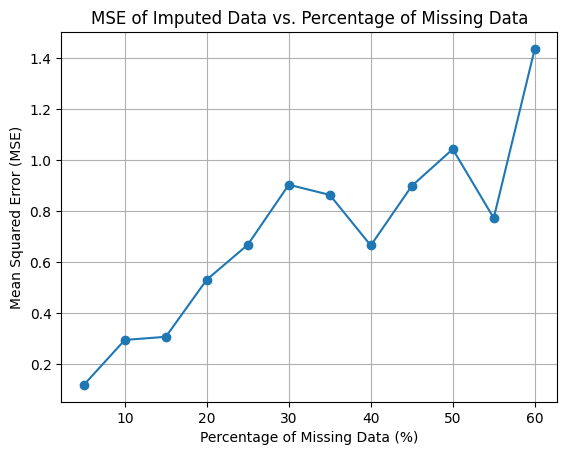

In [16]:
# Range of missing data percentages
missing_data_percentages = np.arange(5, 65, 5)
mse_values = []

# Loop over different percentages of missing data
for p_miss in missing_data_percentages:
    # Simulate missing data
    p_obs = 0.5
    missing_data_info = produce_NA(data, p_miss / 100.0, mecha='MAR', p_obs=p_obs, opt = "quantile")
    X_incomp = missing_data_info['X_incomp'].numpy()

    # Apply EM algorithm
    #imputed_data, _, _ = em_algorithm1(X_incomp)
    imputed_data = updated_impyute.em(X_incomp, eps=0.1)

    # Calculate MSE
    mse = mean_squared_error(data, imputed_data)
    mse_values.append(mse)

# Plotting the results
plt.plot(missing_data_percentages, mse_values, marker='o')
plt.xlabel('Percentage of Missing Data (%)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE of Imputed Data vs. Percentage of Missing Data')
plt.grid(True)
plt.show()

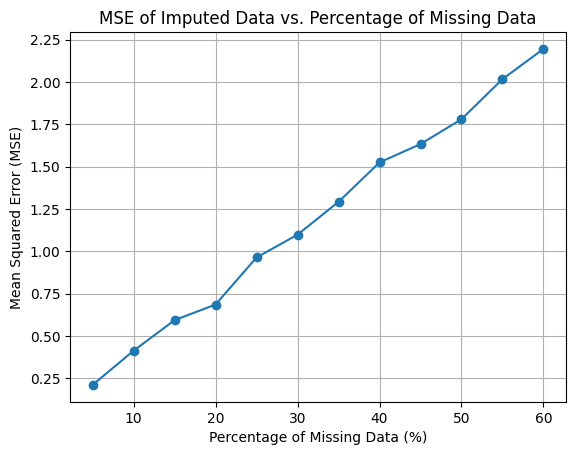

In [17]:
# Range of missing data percentages
missing_data_percentages = np.arange(5, 65, 5)
mse_values = []

# Loop over different percentages of missing data
for p_miss in missing_data_percentages:
    # Simulate missing data
    p_obs = 0.2
    q = 0.7
    missing_data_info = produce_NA(data, p_miss / 100.0, mecha='MNAR',p_obs=p_obs, q=q, opt = "logistic")
    X_incomp = missing_data_info['X_incomp'].numpy()

    # Apply EM algorithm
    #imputed_data, _, _ = em_algorithm1(X_incomp)
    imputed_data = updated_impyute.em(X_incomp, eps=0.1)

    # Calculate MSE
    mse = mean_squared_error(data, imputed_data)
    mse_values.append(mse)

# Plotting the results
plt.plot(missing_data_percentages, mse_values, marker='o')
plt.xlabel('Percentage of Missing Data (%)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE of Imputed Data vs. Percentage of Missing Data')
plt.grid(True)
plt.show()

The eigenvectors are the columns of :
 [[-0.29236729 -0.47799328 -0.44466129 -0.66245022 -0.22244062]
 [-0.46918413 -0.28631325  0.16295061  0.51756828 -0.63518592]
 [-0.33220597  0.82944872 -0.15898624 -0.22637786 -0.35373783]
 [-0.53424645  0.0268869  -0.51408465  0.37476469  0.55599121]
 [-0.54644994 -0.02896663  0.69725446 -0.31872759  0.3358606 ]]
The smallest eigenvalue is : 0.10895965432144239
The eigenvalues below the tolerance of  0.01  are :
 []
We added  0.5  to the diagonal.
The eigenvectors are the columns of :
 [[-0.29553579 -0.48484863 -0.60845542  0.55264518  0.04411026]
 [-0.47049245 -0.24044383  0.27059677 -0.10090225 -0.79838571]
 [-0.33821505  0.83840779 -0.22262413  0.32310955 -0.16947473]
 [-0.52911591  0.0137635  -0.37915942 -0.70978751  0.26886194]
 [-0.54492421 -0.06317849  0.60269066  0.27605063  0.50953519]]
The smallest eigenvalue is : 0.010880822947604962
The eigenvalues below the tolerance of  0.01  are :
 []
We added  0.5  to the diagonal.
The eigenvector

C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


The eigenvectors are the columns of :
 [[-0.27919846 -0.37665012 -0.15219654  0.86884462 -0.04613185]
 [-0.47162745 -0.29552906 -0.23041157 -0.35791238 -0.71346995]
 [-0.31775772  0.83251007  0.16608774  0.27066895 -0.32420701]
 [-0.53333224  0.1832904  -0.59195753 -0.16635075  0.55124864]
 [-0.56053771 -0.21006872  0.7387475  -0.12678131  0.28257254]]
The smallest eigenvalue is : 0.2930725080641468
The eigenvalues below the tolerance of  0.01  are :
 []
We added  0.5  to the diagonal.
The eigenvectors are the columns of :
 [[-0.28674069 -0.32110173 -0.88518185 -0.176195    0.00904856]
 [-0.47298687 -0.28834359  0.26160281 -0.05951012 -0.78813953]
 [-0.33557404  0.89176252 -0.22391511  0.03550159 -0.2018696 ]
 [-0.5283158   0.00738849  0.30149437 -0.64456873  0.4630984 ]
 [-0.5498506  -0.13585535  0.08354782  0.74073251  0.35148649]]
The smallest eigenvalue is : 0.17375775916877248
The eigenvalues below the tolerance of  0.01  are :
 []
We added  0.5  to the diagonal.
The eigenvectors 

C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


The eigenvectors are the columns of :
 [[-0.2857087  -0.90555421  0.20048986 -0.2410648   0.00580444]
 [-0.4689408   0.36751379  0.34828433 -0.54653018 -0.47437425]
 [-0.32779917 -0.12827796 -0.59020664  0.36438068 -0.62847062]
 [-0.52984553  0.13198721 -0.53095908 -0.29554128  0.57669827]
 [-0.55702467  0.10502063  0.45633367  0.65044185  0.21766758]]
The smallest eigenvalue is : 0.3204772752816532
The eigenvalues below the tolerance of  0.01  are :
 []
We added  0.5  to the diagonal.
The eigenvectors are the columns of :
 [[ 0.2904007   0.91931802  0.24483145 -0.08881234 -0.05188202]
 [ 0.47290553 -0.30734218  0.34651285 -0.74196438  0.10639006]
 [ 0.34509897  0.11727023 -0.88377906 -0.21232799  0.20249886]
 [ 0.52865655 -0.16958187 -0.06009398  0.26648566 -0.78558154]
 [ 0.54171648 -0.13373424  0.18790873  0.57052909  0.57257774]]
The smallest eigenvalue is : 0.2460927071388032
The eigenvalues below the tolerance of  0.01  are :
 []
We added  0.5  to the diagonal.
The eigenvectors a

C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


The eigenvectors are the columns of :
 [[-0.27451571 -0.9251144   0.09285145  0.24380928 -0.027205  ]
 [-0.47985687  0.20549591 -0.68933885  0.48928868 -0.11365456]
 [-0.30172649 -0.17185355 -0.42630198 -0.83420006 -0.04247783]
 [-0.51826743  0.20424049  0.48417059 -0.06786321 -0.67131074]
 [-0.5785659   0.17517691  0.31628472 -0.02566079  0.73067096]]
The smallest eigenvalue is : 0.3325644105116452
The eigenvalues below the tolerance of  0.01  are :
 []
We added  0.5  to the diagonal.
The eigenvectors are the columns of :
 [[ 0.28137202  0.94269008 -0.17355942 -0.04186526  0.01701863]
 [ 0.48133394 -0.18744666 -0.31484377 -0.00423805 -0.79626429]
 [ 0.33269245  0.07605205  0.92047894  0.05886927 -0.18106561]
 [ 0.51918849 -0.20338845 -0.04823127 -0.73399961  0.38470088]
 [ 0.55579354 -0.17043589 -0.14540564  0.67528389  0.42999304]]
The smallest eigenvalue is : 0.2025084856868928
The eigenvalues below the tolerance of  0.01  are :
 []
We added  0.5  to the diagonal.
The eigenvectors a

C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


The eigenvectors are the columns of :
 [[-0.26453972 -0.91663916  0.04504115  0.29467792 -0.03045661]
 [-0.46306222  0.31698208  0.0977961   0.4869333  -0.66213867]
 [-0.31000981 -0.14925826  0.18704509 -0.81527145 -0.42657061]
 [-0.51673901  0.16890551  0.63212053  0.02192051  0.5517199 ]
 [-0.59368917  0.09212986 -0.74420762 -0.10446453  0.27255722]]
The smallest eigenvalue is : 0.34212608818641677
The eigenvalues below the tolerance of  0.01  are :
 []
We added  0.5  to the diagonal.
The eigenvectors are the columns of :
 [[ 0.2778506   0.94740366 -0.14804758  0.04946286 -0.02933735]
 [ 0.47356199 -0.20443408 -0.19594303  0.80289048  0.22565227]
 [ 0.3386024   0.04952343  0.93265542  0.00848958  0.11391942]
 [ 0.52010586 -0.18261937 -0.07786523 -0.14224923 -0.81843889]
 [ 0.55980031 -0.15757728 -0.25254527 -0.57672644  0.51517038]]
The smallest eigenvalue is : 0.2459085482607632
The eigenvalues below the tolerance of  0.01  are :
 []
We added  0.5  to the diagonal.
The eigenvectors 

C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


The eigenvectors are the columns of :
 [[ 0.24599297  0.91202832 -0.29042832  0.12419505 -0.08898753]
 [ 0.47413748 -0.2502587  -0.01482756  0.29825874 -0.78954804]
 [ 0.29053476  0.2272136   0.92607324 -0.02392901  0.07602171]
 [ 0.59300684 -0.21785175 -0.17012674  0.45838632  0.60151673]
 [ 0.52783856 -0.08055759 -0.16993172 -0.82760298  0.03306719]]
The smallest eigenvalue is : 0.3456589276630833
The eigenvalues below the tolerance of  0.01  are :
 []
We added  0.5  to the diagonal.
The eigenvectors are the columns of :
 [[-0.26398878 -0.95013065  0.14403616 -0.07898272  0.02402075]
 [-0.48317667  0.19772094  0.30757899 -0.40997342 -0.68173579]
 [-0.32755673 -0.0487943  -0.92719313 -0.05917821 -0.16473174]
 [-0.55828303  0.21545807  0.08242854 -0.35922099  0.71138154]
 [-0.52714028  0.09672188  0.13478569  0.83255135 -0.03819786]]
The smallest eigenvalue is : 0.27726955784976137
The eigenvalues below the tolerance of  0.01  are :
 []
We added  0.5  to the diagonal.
The eigenvectors 

C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


The eigenvectors are the columns of :
 [[ 2.47422016e-01  9.58575905e-01 -1.17386715e-01  7.47979294e-02
  -2.32423953e-02]
 [ 4.64711383e-01 -2.34278414e-01 -4.71604978e-01  7.10264648e-01
  -4.76427304e-02]
 [ 2.93177598e-01 -3.59659864e-04  8.73103917e-01  3.83037113e-01
  -7.08440995e-02]
 [ 5.46502886e-01 -1.25314876e-01 -3.39716442e-02 -4.67254073e-01
  -6.82752031e-01]
 [ 5.81555817e-01 -1.02673810e-01  1.85628816e-02 -3.53391569e-01
   7.25272872e-01]]
The smallest eigenvalue is : 0.36100471330237094
The eigenvalues below the tolerance of  0.01  are :
 []
We added  0.5  to the diagonal.
The eigenvectors are the columns of :
 [[-0.2601307  -0.96197056  0.06539122 -0.04633305 -0.02284517]
 [-0.48041075  0.17413631  0.05327416 -0.85743345  0.0291856 ]
 [-0.33843012  0.01971171 -0.925996    0.13917728  0.09076125]
 [-0.53213413  0.15819476  0.17172342  0.31541003 -0.75022348]
 [-0.55121307  0.13738652  0.32546634  0.37921936  0.6538757 ]]
The smallest eigenvalue is : 0.245951834633

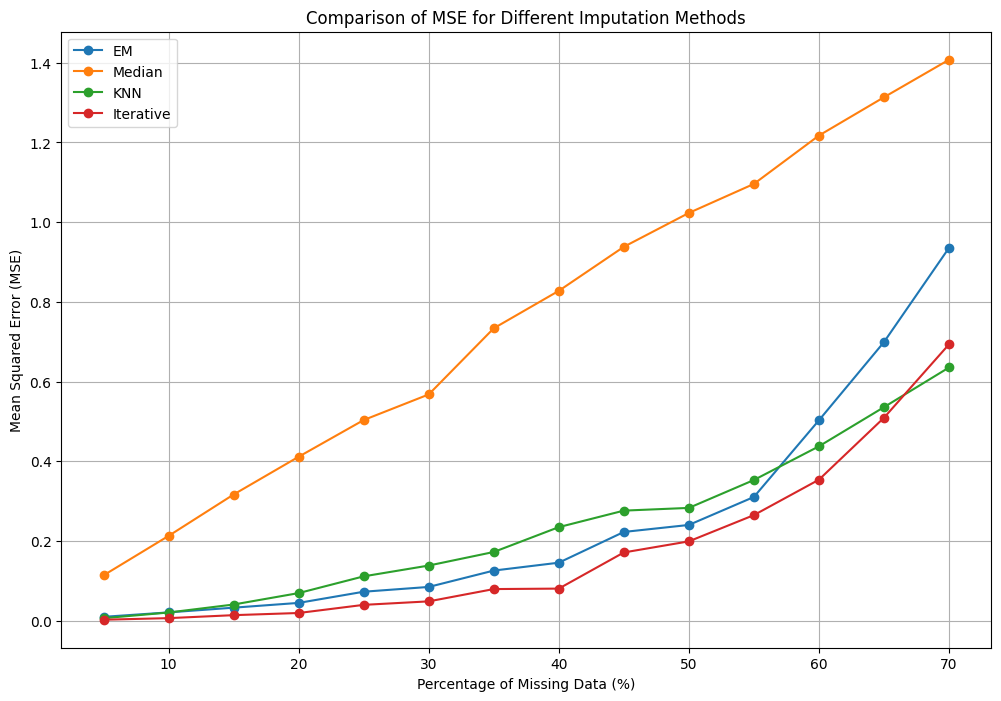

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Generate synthetic data
data = generate_synthetic_data(n_samples=1000, n_features=5)

# Range of missing data percentages
missing_data_percentages = np.arange(5, 75, 5)
methods = ['EM', 'Median', 'KNN', 'Iterative']
mse_values = {method: [] for method in methods}

# Loop over different percentages of missing data
for p_miss in missing_data_percentages:
    missing_data_info = produce_NA(data, p_miss / 100.0)
    X_incomp = missing_data_info['X_incomp'].numpy()

    # EM Algorithm
    imputed_data_em, _, _ = em_algorithm1(X_incomp)
    mse_values['EM'].append(mean_squared_error(data, imputed_data_em))

    # Median Imputation
    imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
    imputed_data_median = imp_median.fit_transform(X_incomp)
    mse_values['Median'].append(mean_squared_error(data, imputed_data_median))

    # KNN Imputation
    imp_knn = KNNImputer(n_neighbors=5)
    imputed_data_knn = imp_knn.fit_transform(X_incomp)
    mse_values['KNN'].append(mean_squared_error(data, imputed_data_knn))

    # Iterative Imputer (Multivariate feature imputation)
    imp_iterative = IterativeImputer(max_iter=100)
    imputed_data_iterative = imp_iterative.fit_transform(X_incomp)
    mse_values['Iterative'].append(mean_squared_error(data, imputed_data_iterative))


# Plotting the results
plt.figure(figsize=(12, 8))
for method in methods:
    plt.plot(missing_data_percentages, mse_values[method], marker='o', label=method)

plt.xlabel('Percentage of Missing Data (%)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of MSE for Different Imputation Methods')
plt.legend()
plt.grid(True)
plt.show()


The eigenvectors are the columns of :
 [[-0.30800528 -0.50319973 -0.69849706 -0.36112314  0.18334316]
 [-0.44872436 -0.27044689 -0.03361363  0.46152923 -0.71509847]
 [-0.35436113  0.81884724 -0.44406092 -0.02020808 -0.07949163]
 [-0.52385242  0.02588055  0.51955218 -0.66140276 -0.13236598]
 [-0.55116788 -0.04967804  0.20939772  0.46767389  0.65664282]]
The smallest eigenvalue is : 0.09932031476025815
The eigenvalues below the tolerance of  0.01  are :
 []
We added  0.5  to the diagonal.
The eigenvectors are the columns of :
 [[-0.29852666 -0.51602888 -0.58220486 -0.54685922 -0.0811081 ]
 [-0.46523043 -0.23249952  0.31527124  0.24947639 -0.75357162]
 [-0.34101506  0.8225994  -0.23031574 -0.30898415 -0.24191405]
 [-0.52795689  0.01860458 -0.4068811   0.64968722  0.3650612 ]
 [-0.5471862  -0.05140292  0.58569955 -0.34805437  0.4834865 ]]
The smallest eigenvalue is : 0.010861937711425712
The eigenvalues below the tolerance of  0.01  are :
 []
We added  0.5  to the diagonal.
The eigenvector

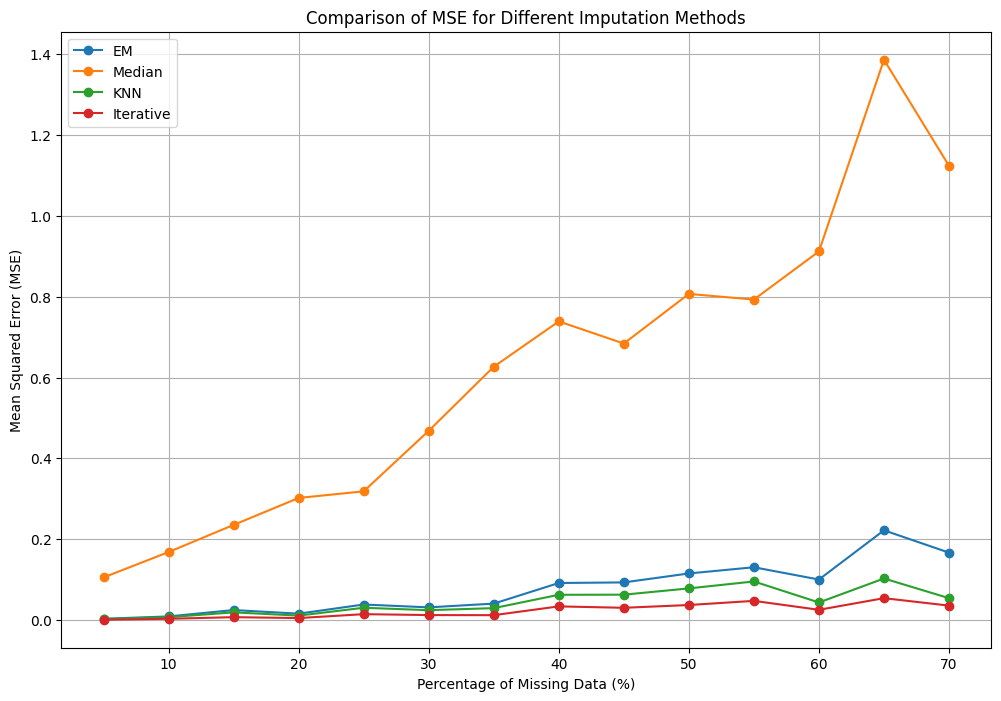

In [19]:
# Range of missing data percentages
missing_data_percentages = np.arange(5, 75, 5)
methods = ['EM', 'Median', 'KNN', 'Iterative']
mse_values = {method: [] for method in methods}

# Loop over different percentages of missing data
for p_miss in missing_data_percentages:
    p_obs = 0.5
    missing_data_info = produce_NA(data, p_miss / 100.0, mecha='MAR', p_obs=p_obs, opt = "quantile")
    X_incomp = missing_data_info['X_incomp'].numpy()

    # EM Algorithm
    imputed_data_em, _, _ = em_algorithm1(X_incomp)
    mse_values['EM'].append(mean_squared_error(data, imputed_data_em))

    # Median Imputation
    imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
    imputed_data_median = imp_median.fit_transform(X_incomp)
    mse_values['Median'].append(mean_squared_error(data, imputed_data_median))

    # KNN Imputation
    imp_knn = KNNImputer(n_neighbors=5)
    imputed_data_knn = imp_knn.fit_transform(X_incomp)
    mse_values['KNN'].append(mean_squared_error(data, imputed_data_knn))

    # Iterative Imputer (Multivariate feature imputation)
    imp_iterative = IterativeImputer(max_iter=100)
    imputed_data_iterative = imp_iterative.fit_transform(X_incomp)
    mse_values['Iterative'].append(mean_squared_error(data, imputed_data_iterative))


# Plotting the results
plt.figure(figsize=(12, 8))
for method in methods:
    plt.plot(missing_data_percentages, mse_values[method], marker='o', label=method)

plt.xlabel('Percentage of Missing Data (%)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of MSE for Different Imputation Methods')
plt.legend()
plt.grid(True)
plt.show()

The eigenvectors are the columns of :
 [[-0.29056624 -0.48116376 -0.40344738  0.71983862 -0.05581462]
 [-0.46849436 -0.29753753  0.0720896  -0.40370737 -0.72374574]
 [-0.34186872  0.82154725 -0.13338858  0.31280387 -0.30421559]
 [-0.531838    0.04910003 -0.51545588 -0.43096859  0.51313627]
 [-0.54438811 -0.05101133  0.74063893  0.18780983  0.34237534]]
The smallest eigenvalue is : 0.14321721629598338
The eigenvalues below the tolerance of  0.01  are :
 []
We added  0.5  to the diagonal.
The eigenvectors are the columns of :
 [[-0.29666091 -0.47804577 -0.56180693  0.60649097  0.00249404]
 [-0.46934682 -0.24259545  0.18632894 -0.24494046 -0.79129433]
 [-0.33998513  0.84066999 -0.19740554  0.31428837 -0.19984483]
 [-0.52719042  0.01969353 -0.41093085 -0.6246621   0.40325614]
 [-0.54606432 -0.07420121  0.66469646  0.28843189  0.41387631]]
The smallest eigenvalue is : 0.02055120908654504
The eigenvalues below the tolerance of  0.01  are :
 []
We added  0.5  to the diagonal.
The eigenvectors

C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


The eigenvectors are the columns of :
 [[-0.28921114 -0.35466131 -0.85738477 -0.23538123  0.00770094]
 [-0.46082372 -0.28702829  0.27289488 -0.0213134  -0.79393349]
 [-0.30779943  0.82167155 -0.31420115  0.27697392 -0.23383425]
 [-0.55644626  0.22249803  0.28000774 -0.65982317  0.35649858]
 [-0.54738057 -0.25919223  0.11529541  0.6573129   0.43340583]]
The smallest eigenvalue is : 0.26835220304271856
The eigenvalues below the tolerance of  0.01  are :
 []
We added  0.5  to the diagonal.
The eigenvectors are the columns of :
 [[-0.29192122 -0.36226264 -0.85413487 -0.23163911 -0.01856688]
 [-0.4686809  -0.27821049  0.243705    0.18960023 -0.77948494]
 [-0.32324659  0.88145021 -0.27830639  0.07031548 -0.19015379]
 [-0.54442302  0.02694888  0.36183613 -0.7109323   0.25792872]
 [-0.54243473 -0.11697862  0.05178484  0.63247615  0.53793384]]
The smallest eigenvalue is : 0.15661196355022497
The eigenvalues below the tolerance of  0.01  are :
 []
We added  0.5  to the diagonal.
The eigenvectors

C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


The eigenvectors are the columns of :
 [[ 0.28436371  0.27782682  0.87225525  0.19143873 -0.21088274]
 [ 0.48394345  0.18641113 -0.39574094 -0.02084273 -0.75763072]
 [ 0.32141702 -0.89022302  0.20114271 -0.22597016 -0.11257515]
 [ 0.53235975 -0.08521004 -0.20387767  0.70913627  0.40606896]
 [ 0.54609543  0.29716218 -0.02313868 -0.63951547  0.45161819]]
The smallest eigenvalue is : 0.3029522993770238
The eigenvalues below the tolerance of  0.01  are :
 []
We added  0.5  to the diagonal.
The eigenvectors are the columns of :
 [[-0.29626258 -0.28697323 -0.8847863  -0.17605113 -0.1266256 ]
 [-0.4789238  -0.25682725  0.33088603  0.11078259 -0.76348766]
 [-0.34336471  0.9070708  -0.1726807   0.07738871 -0.15334797]
 [-0.52578917 -0.02490658  0.27716607 -0.72186516  0.3535747 ]
 [-0.53712839 -0.1681914   0.03206201  0.65548066  0.50251554]]
The smallest eigenvalue is : 0.19604593846439247
The eigenvalues below the tolerance of  0.01  are :
 []
We added  0.5  to the diagonal.
The eigenvectors 

C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


The eigenvectors are the columns of :
 [[-0.24805996 -0.17315882 -0.42640975  0.75072395 -0.40381996]
 [-0.49624171 -0.21293428  0.01469568 -0.54819012 -0.63849415]
 [-0.33737022  0.88543762  0.23938164  0.14631776 -0.15319627]
 [-0.53455253  0.08814265 -0.60377358 -0.20457358  0.54780615]
 [-0.54096705 -0.36456289  0.62937481  0.26952163  0.32510611]]
The smallest eigenvalue is : 0.3776755281823424
The eigenvalues below the tolerance of  0.01  are :
 []
We added  0.5  to the diagonal.
The eigenvectors are the columns of :
 [[-0.27459009 -0.2724568  -0.86434134 -0.24812483 -0.2042442 ]
 [-0.48824914 -0.23579358  0.39920306  0.01706282 -0.73916165]
 [-0.35235751  0.90710991 -0.16276195  0.07833402 -0.14271696]
 [-0.52437583 -0.02672741  0.2518508  -0.65923907  0.47570018]
 [-0.53580522 -0.21588411 -0.06025521  0.70527339  0.40652868]]
The smallest eigenvalue is : 0.27065292253645695
The eigenvalues below the tolerance of  0.01  are :
 []
We added  0.5  to the diagonal.
The eigenvectors 

C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


The eigenvectors are the columns of :
 [[-0.30798497 -0.13234369 -0.24775578 -0.90531601  0.08155001]
 [-0.4871647  -0.27510598 -0.27753803  0.21424836 -0.75103764]
 [-0.34005862  0.04152959  0.90988313 -0.15516588 -0.17513328]
 [-0.57268318 -0.42373327 -0.02007281  0.31855904  0.62498106]
 [-0.47350811  0.85177888 -0.18248149  0.09457405  0.08954925]]
The smallest eigenvalue is : 0.3081479360441572
The eigenvalues below the tolerance of  0.01  are :
 []
We added  0.5  to the diagonal.
The eigenvectors are the columns of :
 [[-0.30508603 -0.91382976  0.04495304 -0.24030062 -0.10987502]
 [-0.48375007  0.23243944 -0.74224582 -0.27498838 -0.29225042]
 [-0.35572126 -0.12796245 -0.14427224  0.91445323 -0.00698675]
 [-0.54436883  0.28628049  0.64674617 -0.07306278 -0.44506997]
 [-0.50003334  0.11205429  0.08919239 -0.15834813  0.83927414]]
The smallest eigenvalue is : 0.2570492867230565
The eigenvalues below the tolerance of  0.01  are :
 []
We added  0.5  to the diagonal.
The eigenvectors a

C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


The eigenvectors are the columns of :
 [[ 0.28901574  0.82026241  0.09695402 -0.44233103 -0.19642468]
 [ 0.46646219 -0.55982333  0.18314311 -0.65395044 -0.0884211 ]
 [ 0.29801417  0.015546   -0.91409559 -0.09172218  0.25877048]
 [ 0.53625583 -0.06551695 -0.06600341  0.51015925 -0.6659717 ]
 [ 0.56789098  0.09608988  0.34224452  0.32865889  0.66567153]]
The smallest eigenvalue is : 0.3772184028106026
The eigenvalues below the tolerance of  0.01  are :
 []
We added  0.5  to the diagonal.
The eigenvectors are the columns of :
 [[-0.30456163 -0.18944211 -0.90838244 -0.20214245 -0.07303201]
 [-0.46752044 -0.25155452  0.36890335 -0.75563494  0.10521943]
 [-0.34049669  0.92329899 -0.06372258 -0.11059286  0.12365126]
 [-0.52307052 -0.03975824  0.17552782  0.31517949 -0.77114745]
 [-0.5469242  -0.21626435  0.06229836  0.52591386  0.61125868]]
The smallest eigenvalue is : 0.41794983279872655
The eigenvalues below the tolerance of  0.01  are :
 []
We added  0.5  to the diagonal.
The eigenvectors 

C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


The eigenvectors are the columns of :
 [[ 0.2401993   0.32430204 -0.89825543  0.1460656   0.09452253]
 [ 0.44048504  0.42871117  0.33815708  0.62495058 -0.34244157]
 [ 0.25432405 -0.37952583 -0.19883163 -0.26387127 -0.82590396]
 [ 0.62738006  0.31553152  0.19773486 -0.65129749  0.20867829]
 [ 0.5385079  -0.68369213 -0.01240475  0.30705888  0.38488346]]
The smallest eigenvalue is : 0.28364191752984574
The eigenvalues below the tolerance of  0.01  are :
 []
We added  0.5  to the diagonal.
The eigenvectors are the columns of :
 [[ 0.25106603  0.93929135 -0.23286766 -0.02158287  0.0021089 ]
 [ 0.4589599  -0.24933223 -0.50449375 -0.13473077 -0.67418316]
 [ 0.29268175  0.08803701  0.720717   -0.5654645  -0.25962237]
 [ 0.59784852 -0.21603354 -0.19389243 -0.28789483  0.68951356]
 [ 0.5321994  -0.03382594  0.3663761   0.76075506 -0.05137993]]
The smallest eigenvalue is : 0.2143216267750862
The eigenvalues below the tolerance of  0.01  are :
 []
We added  0.5  to the diagonal.
The eigenvectors 

C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


The eigenvectors are the columns of :
 [[-0.27737645 -0.07161606 -0.8751782  -0.33733611  0.19545056]
 [-0.4799617   0.36081284  0.23702199 -0.58282868 -0.49354045]
 [-0.28564692 -0.33051144 -0.23813998  0.52104754 -0.69351773]
 [-0.52690661 -0.69042917  0.347248   -0.13062752  0.32868261]
 [-0.57747237  0.52797252  0.02432848  0.50789861  0.35946879]]
The smallest eigenvalue is : 0.327928015678762
The eigenvalues below the tolerance of  0.01  are :
 []
We added  0.5  to the diagonal.
The eigenvectors are the columns of :
 [[-0.27633229 -0.94888991  0.00471621 -0.15077588 -0.02219904]
 [-0.48542742  0.16686797  0.40626568 -0.03662605 -0.75506426]
 [-0.33241667 -0.02665493 -0.522307    0.77697187 -0.11089984]
 [-0.5219312   0.23877943 -0.56692011 -0.58030737  0.11143228]
 [-0.55234741  0.1184775   0.49063524  0.18836994  0.63613618]]
The smallest eigenvalue is : 0.27124913905047987
The eigenvalues below the tolerance of  0.01  are :
 []
We added  0.5  to the diagonal.
The eigenvectors a

C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


The eigenvectors are the columns of :
 [[-0.20573171 -0.93306449  0.14668408 -0.21626185  0.13703912]
 [-0.49990071  0.25706866  0.32484287 -0.65654854 -0.3839741 ]
 [-0.33794473 -0.17785259 -0.59931576  0.27089012 -0.64930807]
 [-0.49461419  0.16212637 -0.54116928 -0.19645248  0.63056648]
 [-0.59069782  0.0734157   0.47001842  0.64046842  0.12070257]]
The smallest eigenvalue is : 0.3333132625323333
The eigenvalues below the tolerance of  0.01  are :
 []
We added  0.5  to the diagonal.
The eigenvectors are the columns of :
 [[-0.21275968 -0.97474076  0.0618288   0.02229231 -0.0171472 ]
 [-0.50039958  0.15332627  0.45022296  0.13263596 -0.71119498]
 [-0.36025395  0.02528756 -0.78482628 -0.39557565 -0.31168133]
 [-0.50433691  0.10363341 -0.2726196   0.7372544   0.34210948]
 [-0.56585771  0.12244251  0.32125185 -0.53092994  0.52888895]]
The smallest eigenvalue is : 0.2855485995911153
The eigenvalues below the tolerance of  0.01  are :
 []
We added  0.5  to the diagonal.
The eigenvectors a

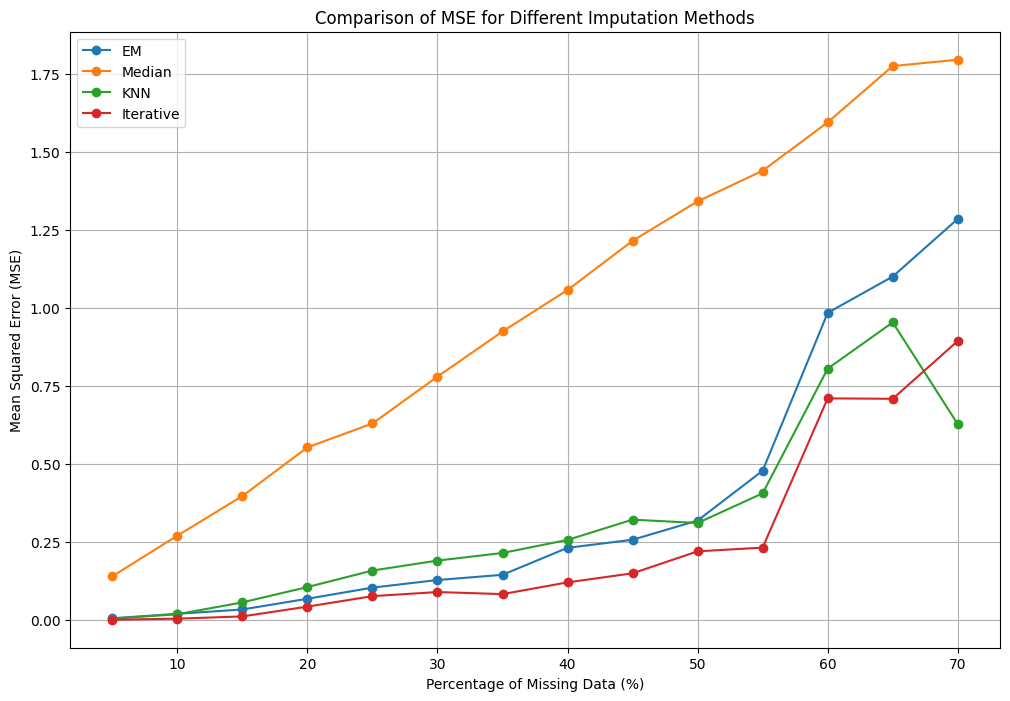

In [20]:
# Range of missing data percentages
missing_data_percentages = np.arange(5, 75, 5)
methods = ['EM', 'Median', 'KNN', 'Iterative']
mse_values = {method: [] for method in methods}

# Loop over different percentages of missing data
for p_miss in missing_data_percentages:
    p_obs = 0.2
    q = 0.7
    missing_data_info = produce_NA(data, p_miss / 100.0, mecha='MNAR',p_obs=p_obs, q=q, opt = "logistic")
    X_incomp = missing_data_info['X_incomp'].numpy()

    # EM Algorithm
    imputed_data_em, _, _ = em_algorithm1(X_incomp)
    mse_values['EM'].append(mean_squared_error(data, imputed_data_em))

    # Median Imputation
    imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
    imputed_data_median = imp_median.fit_transform(X_incomp)
    mse_values['Median'].append(mean_squared_error(data, imputed_data_median))

    # KNN Imputation
    imp_knn = KNNImputer(n_neighbors=5)
    imputed_data_knn = imp_knn.fit_transform(X_incomp)
    mse_values['KNN'].append(mean_squared_error(data, imputed_data_knn))

    # Iterative Imputer (Multivariate feature imputation)
    imp_iterative = IterativeImputer(max_iter=100)
    imputed_data_iterative = imp_iterative.fit_transform(X_incomp)
    mse_values['Iterative'].append(mean_squared_error(data, imputed_data_iterative))


# Plotting the results
plt.figure(figsize=(12, 8))
for method in methods:
    plt.plot(missing_data_percentages, mse_values[method], marker='o', label=method)

plt.xlabel('Percentage of Missing Data (%)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of MSE for Different Imputation Methods')
plt.legend()
plt.grid(True)
plt.show()

The eigenvectors are the columns of :
 [[-1.95781241e-03 -6.70638109e-03 -3.59357006e-06 -3.84042145e-01
  -9.15451614e-01  7.32007636e-02 -5.84238838e-02 -6.38788050e-02
   3.68154372e-02 -1.36949776e-02  3.95436024e-03  6.28231393e-04]
 [-2.00451642e-04 -3.16850025e-04  8.01653706e-04 -8.81512692e-03
   1.87578423e-02 -3.20084410e-02  1.43914670e-01  7.54571612e-02
   9.23832774e-01  3.44178027e-01  1.46264876e-02 -6.74499044e-04]
 [-2.14292469e-04 -6.38233682e-04 -5.85722687e-04  2.56771376e-03
  -5.10498420e-02 -7.75437108e-03 -2.17030193e-01  5.85108977e-01
  -2.83045578e-01  7.25731917e-01 -3.27082844e-02  5.71288123e-04]
 [-5.27322386e-02 -4.42316491e-03  9.96663579e-01  4.82873888e-02
  -2.17952753e-02 -3.08767748e-02 -9.53172212e-03 -1.15524401e-03
   1.48222857e-03 -2.56548435e-03  5.48528534e-04  3.28221175e-04]
 [-9.65165051e-05  1.96326597e-05  4.27156448e-05 -4.68116652e-03
   3.65509859e-03  3.28116427e-03  7.06330777e-03  1.35034497e-02
  -2.76303941e-02  2.57849550e-02

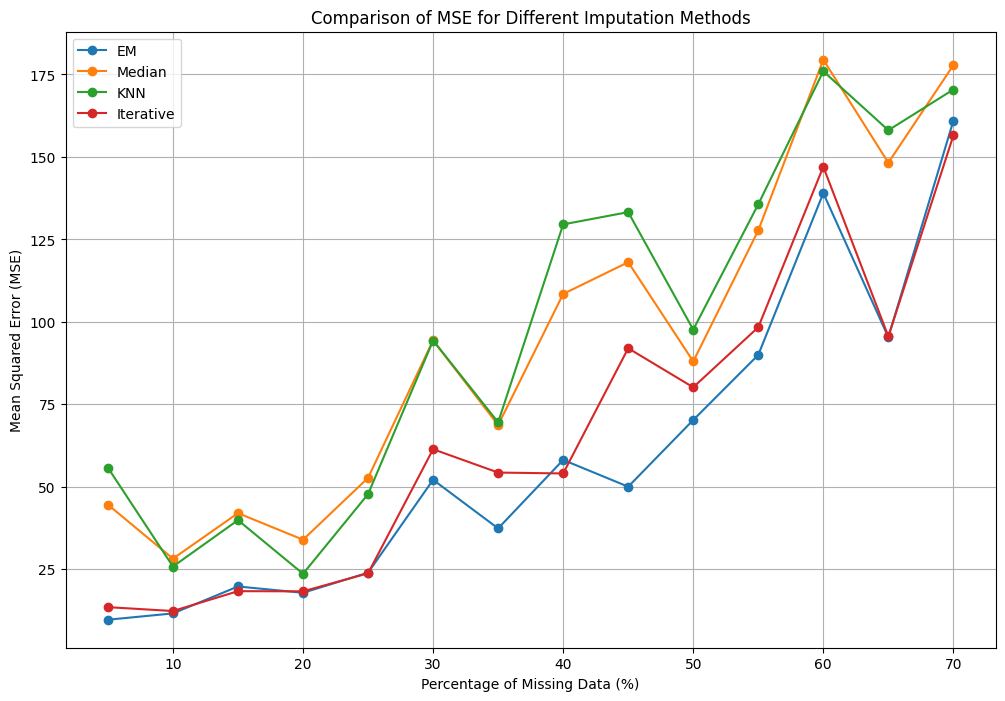

In [21]:
# dataset from https://archive.ics.uci.edu/dataset/186/wine+quality
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Load the Wine Quality dataset
wine_data = pd.read_csv('winequality-white.csv', delimiter=';')
# Take a random subset of 500 samples
wine_data_subset = wine_data.sample(n=200, random_state=124)

# Convert to numpy array
data = wine_data_subset.to_numpy()

# Range of missing data percentages and methods
missing_data_percentages = np.arange(5, 75, 5)
methods = ['EM', 'Median', 'KNN', 'Iterative']
mse_values = {method: [] for method in methods}

# Loop over different percentages of missing data
for p_miss in missing_data_percentages:
    # Simulate missing data
    missing_data_info = produce_NA(data, p_miss / 100.0)
    X_incomp = missing_data_info['X_incomp'].numpy()

    # EM Algorithm
    imputed_data_em, _, _ = em_algorithm1(X_incomp)
    mse_values['EM'].append(mean_squared_error(data, imputed_data_em))

    # Median Imputation
    imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
    imputed_data_median = imp_median.fit_transform(X_incomp)
    mse_values['Median'].append(mean_squared_error(data, imputed_data_median))

    # KNN Imputation
    imp_knn = KNNImputer(n_neighbors=5)
    imputed_data_knn = imp_knn.fit_transform(X_incomp)
    mse_values['KNN'].append(mean_squared_error(data, imputed_data_knn))

    # Iterative Imputer (Multivariate feature imputation)
    imp_iterative = IterativeImputer(max_iter=100)
    imputed_data_iterative = imp_iterative.fit_transform(X_incomp)
    mse_values['Iterative'].append(mean_squared_error(data, imputed_data_iterative))


# Plotting the results
plt.figure(figsize=(12, 8))
for method in methods:
    plt.plot(missing_data_percentages, mse_values[method], marker='o', label=method)

plt.xlabel('Percentage of Missing Data (%)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of MSE for Different Imputation Methods')
plt.legend()
plt.grid(True)
plt.show()